In [1]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace
#from statsmodels.stats.proportion import proportion_ztest

# Step 1: Acquire Data From CSV File

In [2]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [3]:
beach_clean = beach_complete.dropna()

In [4]:
beach_clean.apply(pd.to_numeric);

In [5]:
beach_clean['average'] = beach_clean.mean(1)

/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
beach_clean.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9,average
sampleDate,,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0,26.636364
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0,18.090909
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0,12.000000
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0,11.727273
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0,14.454545
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0,25.000000
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0,83.909091
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0,76.454545
2009-06-10,170.0,25.0,155.0,26.0,11.0,18.0,21.0,11.0,12.0,18.0,31.0,45.272727


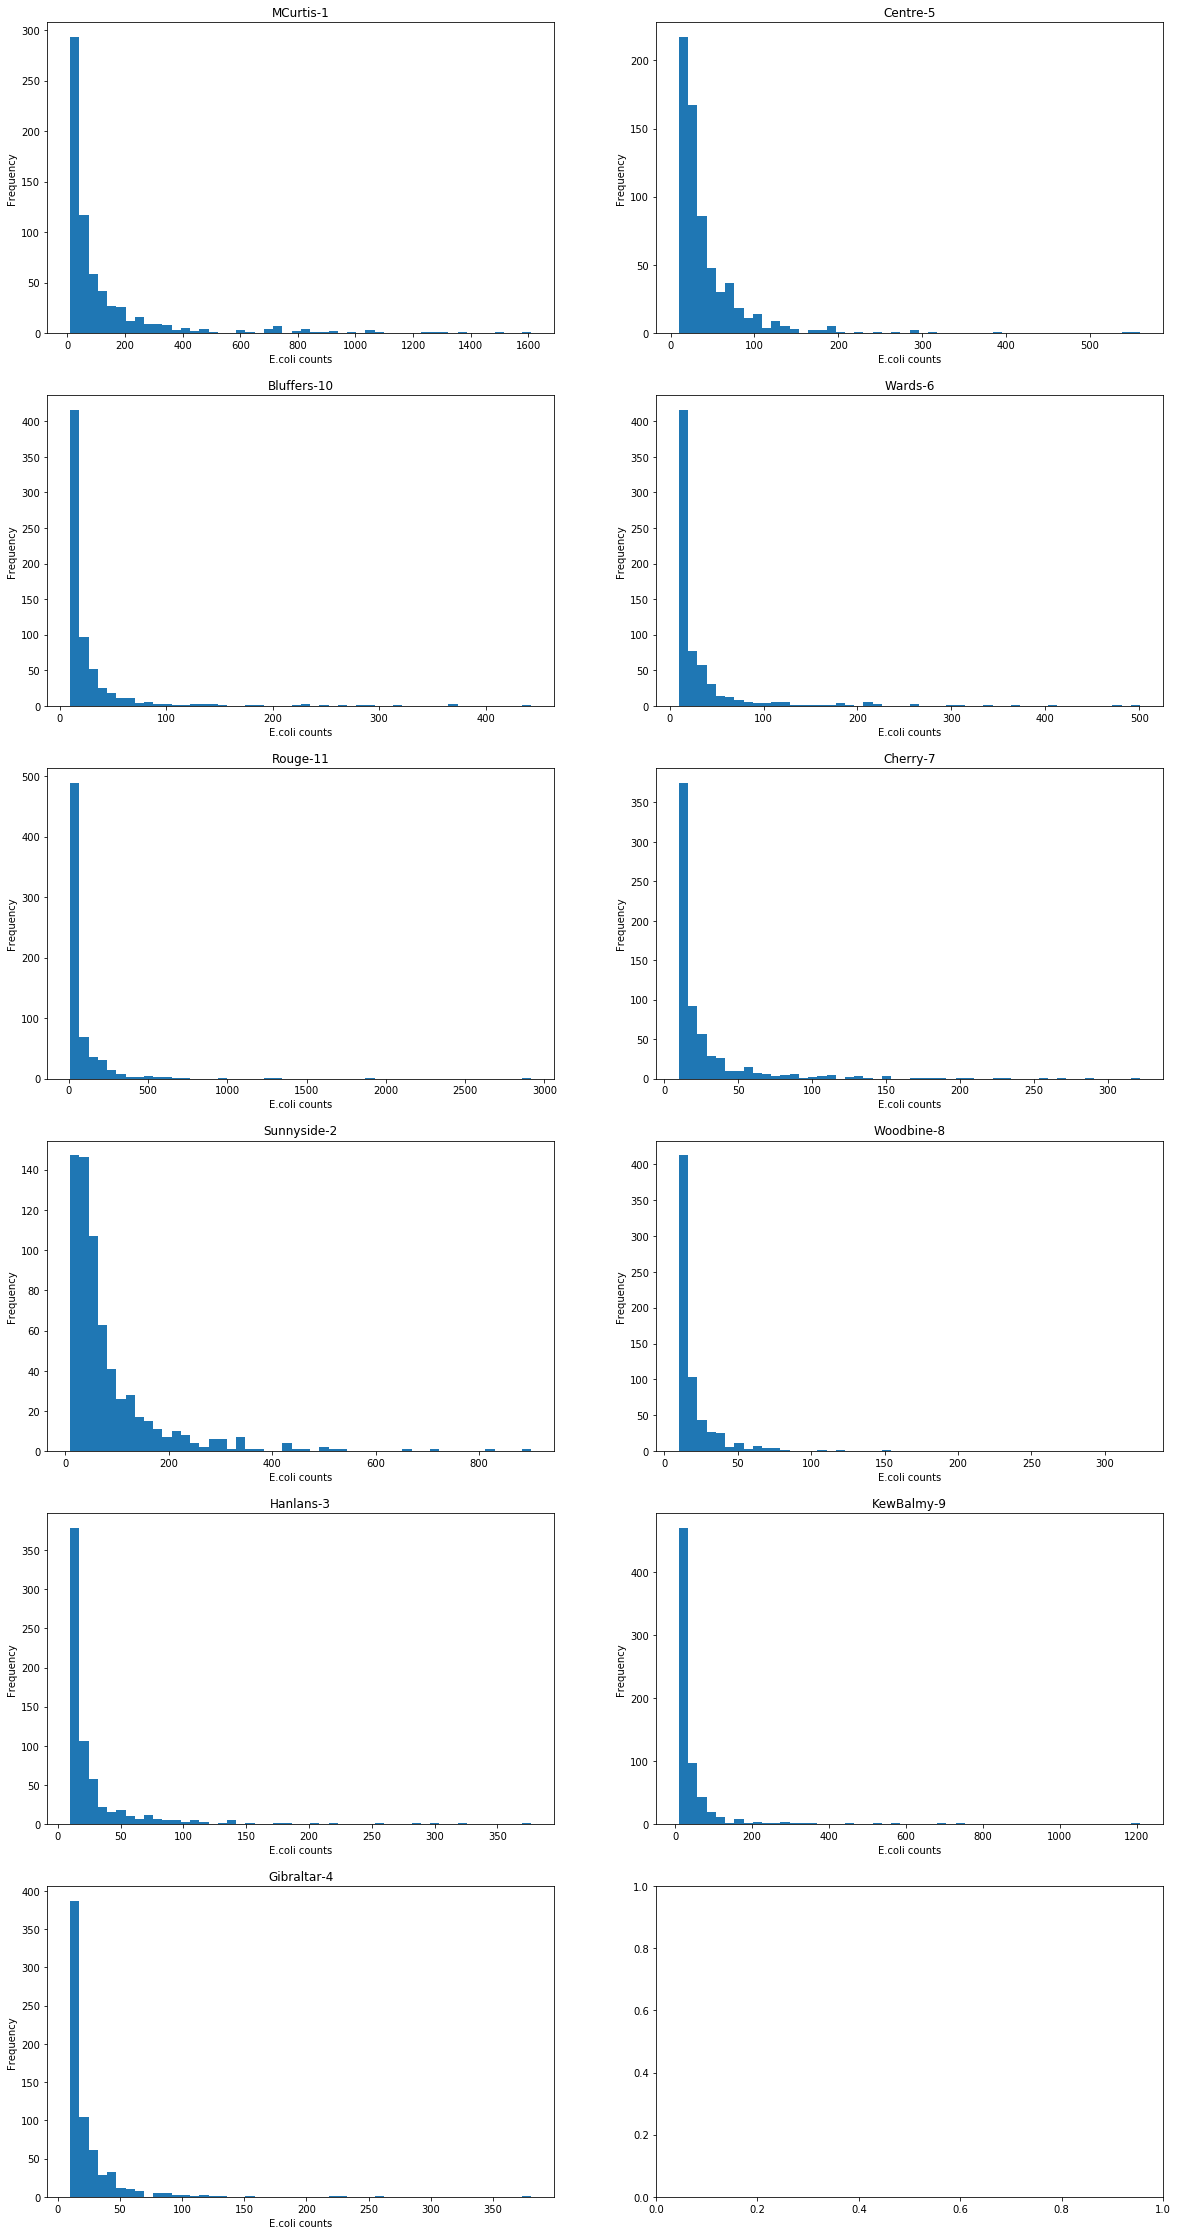

In [7]:
fig, ax = plt.subplots(6, 2, figsize=(20,40))
cols = beach_clean.columns
for i in range(6):
    for j in range(2):
        if j == 1 and i == 5:
            break
        elif j == 0:
            ax[i][j].hist(beach_clean[cols[i]].values, bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
        else:
            ax[i][j].hist(beach_clean[cols[i+6]].values, bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])

In [8]:
#Separate all beach data for predictive analysis
mcurtis = beach_clean[['MCurtis-1']]
sunnyside = beach_clean[['Sunnyside-2']]
hanlans = beach_clean[['Hanlans-3']]
gibraltar = beach_clean[['Gibraltar-4']]
centre = beach_clean[['Centre-5']]
wards = beach_clean[['Wards-6']]
cherry = beach_clean[['Cherry-7']]
woodbine = beach_clean[['Woodbine-8']]
kewbalmy = beach_clean[['KewBalmy-9']]
bluffers = beach_clean[['Bluffers-10']]
rouge = beach_clean[['Rouge-11']]

In [9]:
#Reset index of all beaches
mcurtis = mcurtis.reset_index()
sunnyside = sunnyside.reset_index()
hanlans = hanlans.reset_index()
gibraltar = gibraltar.reset_index()
centre = centre.reset_index()
wards = wards.reset_index()
cherry = cherry.reset_index()
woodbine = woodbine.reset_index()
kewbalmy = kewbalmy.reset_index()
bluffers = bluffers.reset_index()
rouge = rouge.reset_index()

# Step 2: ACF and PACF plots

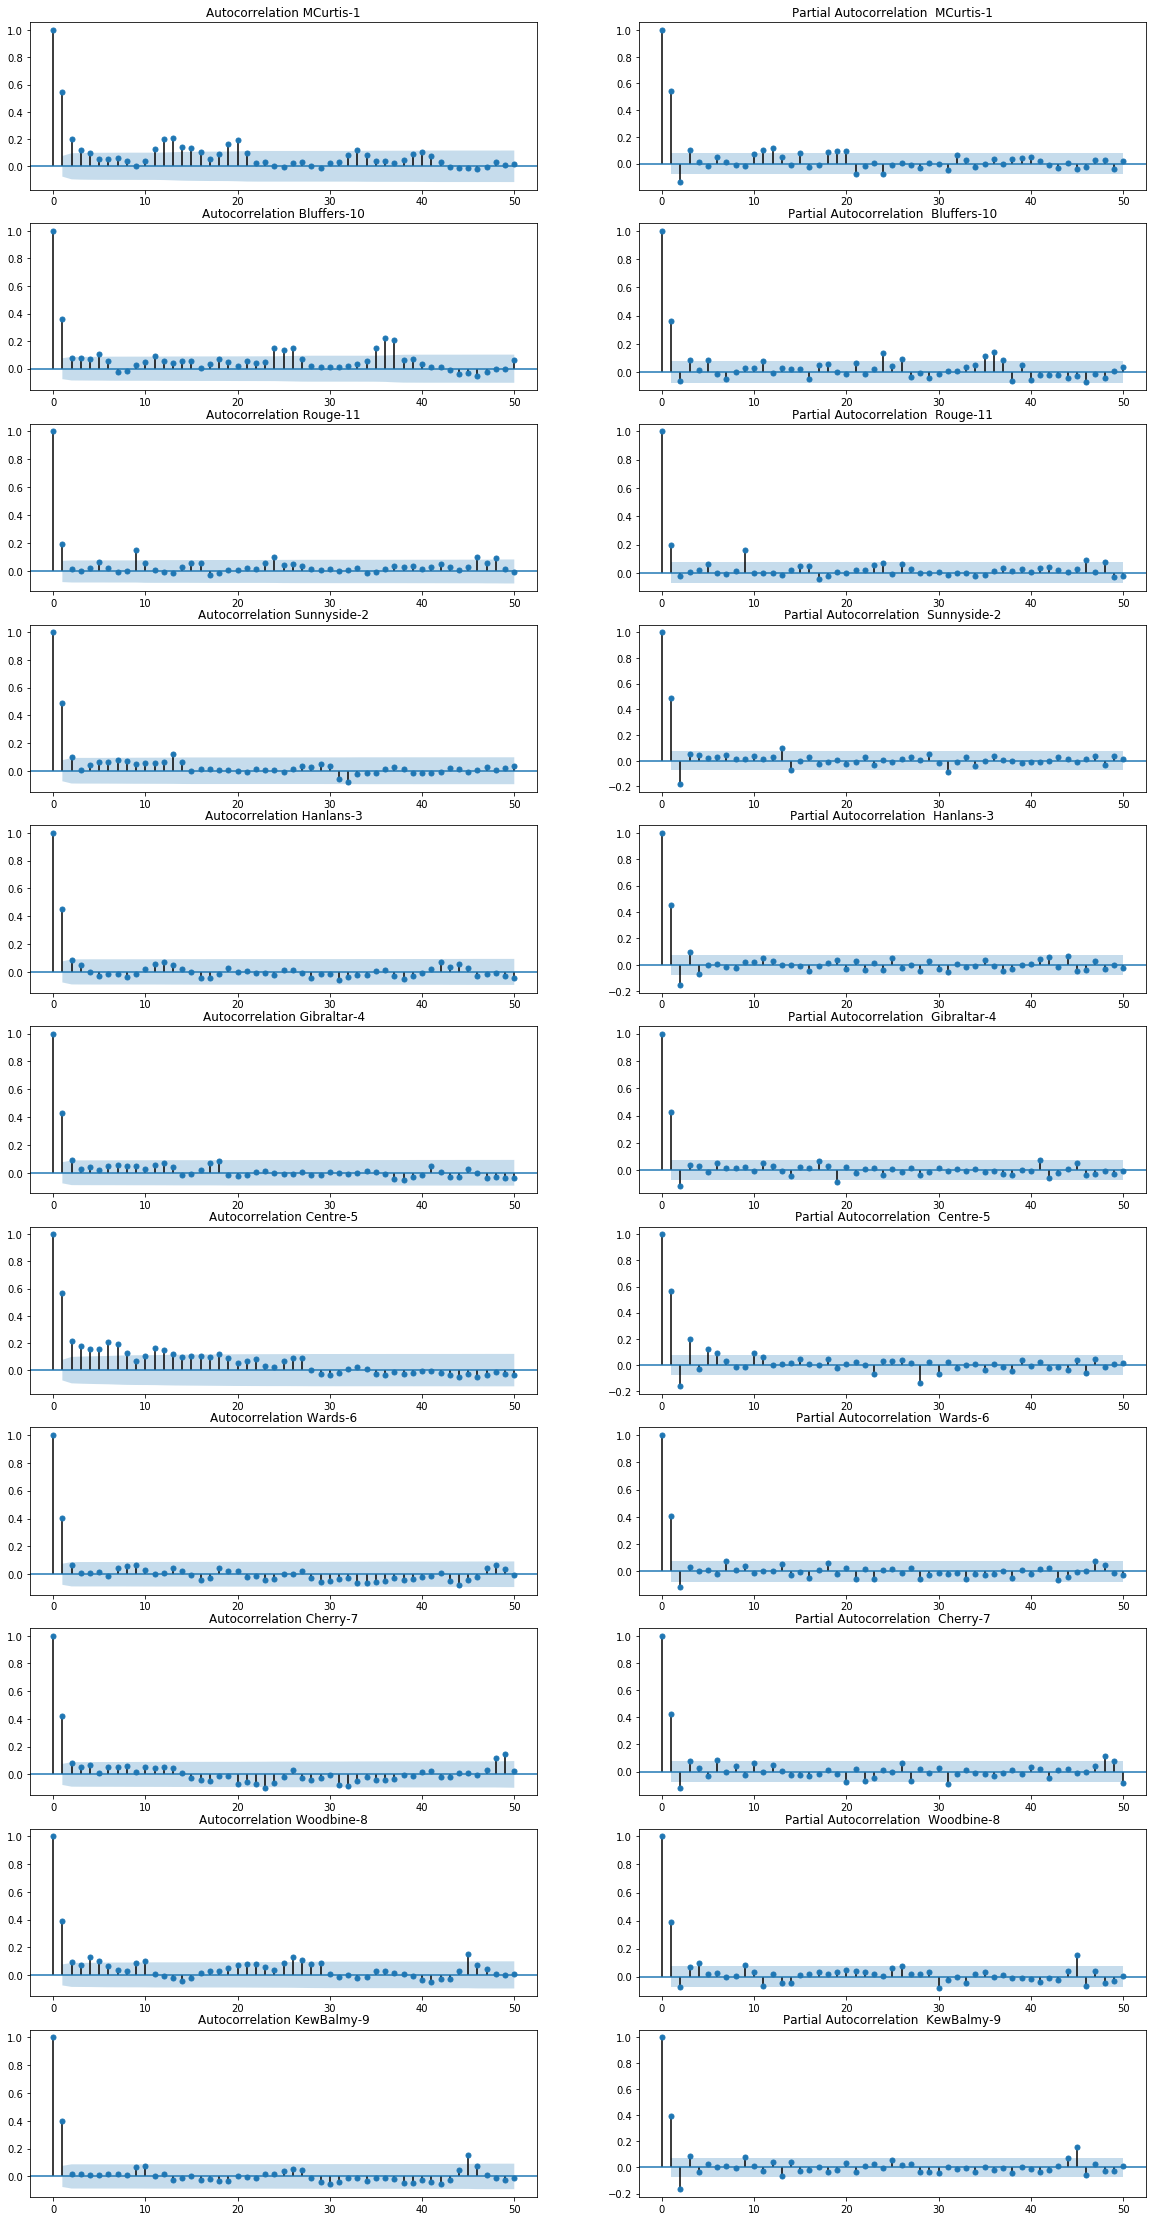

In [10]:
row = 11 #rows of graphs
col = 2 #columns of the graphs
beach_titles = beach_clean.columns #titles of the beaches

fig, ax = plt.subplots(row, col, figsize=(20,40))
for i in range(row):
    for j in range(col):
        if j == 0:
            str_title_acf = "Autocorrelation " + beach_titles[i]
            plot_acf(beach_clean[beach_titles[i]], lags=50, title=str_title_acf, ax=ax[i][j])
        else:
            str_title_pacf = "Partial Autocorrelation  " + beach_titles[i]
            plot_pacf(beach_clean[beach_titles[i]], lags=50, title=str_title_pacf, ax=ax[i][j])

For all 11 beaches, it seems that with a lag=6 there will be very little partial correlation. So we assume lag=6 for both our AR and MA parameters for now.

# Step 3: Setup Train and Test

In [11]:
train_size = int(0.7 * centre['Centre-5'].size)
test_size = int(0.3 * centre['Centre-5'].size)

In [12]:
train_size, test_size

(467, 200)

In [13]:
mcurtis['Label'] = 0
for i in mcurtis.index:
    if i >= train_size:
        mcurtis.loc[i, 'Label'] = 1

In [14]:
sunnyside['Label'] = 0
for i in sunnyside.index:
    if i >= train_size:
        sunnyside.loc[i, 'Label'] = 1

In [15]:
centre['Label'] = 0
for i in centre.index:
    if i >= train_size:
        centre.loc[i, 'Label'] = 1

# Step 4: ARIMA Model 

In [ ]:
mcurtis['Predictions'] = 0
mcurtis['Errors'] = 0

In [15]:
sunnyside['Predictions'] = 0
sunnyside['Errors'] = 0

In [16]:
sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values;

In [17]:
for i in sunnyside.index:
    if sunnyside.loc[i, 'Label'] == 1:
        model = ARIMA(endog=sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values, order=(5,1,1)).fit()
        sunnyside.loc[i, 'Predictions'] = model.forecast()[0][0]
        sunnyside.loc[i, 'Errors'] = model.forecast()[1][0]
        sunnyside.loc[i, 'Label'] = 0

In [18]:
sunnyside['sampleDate'] = pd.to_datetime(sunnyside['sampleDate'])
years = sunnyside['sampleDate'].dt.year
years = years.drop_duplicates()
years

0      2009
48     2010
125    2011
201    2012
263    2013
330    2014
392    2015
465    2016
537    2017
593    2018
Name: sampleDate, dtype: int64

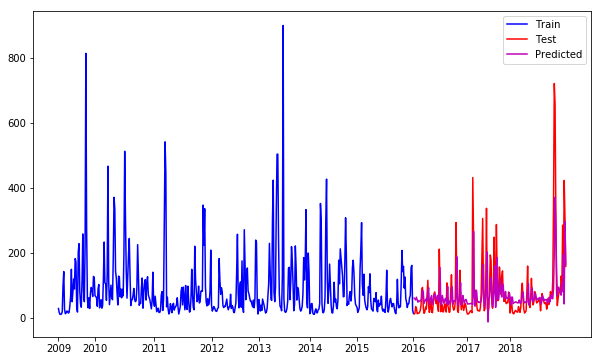

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(sunnyside.index[:train_size], sunnyside['Sunnyside-2'][:train_size], 'b-', label='Train')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Sunnyside-2'][train_size:train_size+test_size], 'r-', label='Test')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Predictions'][train_size:train_size+test_size], 'm-', label='Predicted')
plt.xticks(years.index, years)
plt.legend()
plt.show();

In [21]:
centre['Predictions'] = 0
centre['Errors'] = 0

In [22]:
for i in centre.index:
    if centre.loc[i, 'Label'] == 1:
        model = ARIMA(endog=centre['Centre-5'][centre['Label'] == 0].values,order=(7,1,1)).fit()
        centre.loc[i, 'Predictions'] = model.forecast()[0][0]
        centre.loc[i, 'Errors'] = model.forecast()[1][0]
        centre.loc[i, 'Label'] = 0

In [23]:
centre['sampleDate'] = pd.to_datetime(centre['sampleDate'])
years = centre['sampleDate'].dt.year
years = years.drop_duplicates()
years

0      2009
48     2010
125    2011
201    2012
263    2013
330    2014
392    2015
465    2016
537    2017
593    2018
Name: sampleDate, dtype: int64

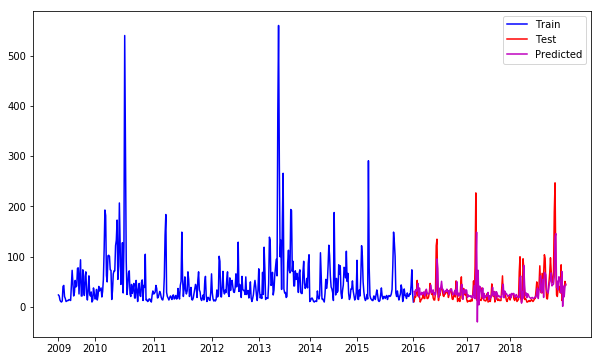

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(centre.index[:train_size], centre['Centre-5'][:train_size], 'b-', label='Train')
ax.plot(centre.index[train_size:train_size+test_size], 
        centre['Centre-5'][train_size:train_size+test_size], 'r-', label='Test')
ax.plot(centre.index[train_size:train_size+test_size], 
        centre['Predictions'][train_size:train_size+test_size], 'm-', label='Predicted')
plt.xticks(years.index, years)
plt.legend()
plt.show();

# Step 5: ARIMA Model Test Results 

In [25]:
rmse = np.sqrt(mean_squared_error(sunnyside['Sunnyside-2'][train_size:train_size+test_size],
                                  sunnyside['Predictions'][train_size:train_size+test_size]))
rmse

79.22660541587126

In [26]:
rmse = np.sqrt(mean_squared_error(centre['Centre-5'][train_size:train_size+test_size],
                                  centre['Predictions'][train_size:train_size+test_size]))
rmse

27.417419250571992